<a href="https://colab.research.google.com/github/harel-coffee/npj-corrections/blob/main/Copy_of_Scripts_For_npj_Digital_Medicine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Import the necessary Library</h2>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math,scipy
import pickle
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.linear_model import PoissonRegressor
import statsmodels.api as sm
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,precision_score, recall_score
from sklearn.preprocessing import scale
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from itertools import cycle
%matplotlib inline  

<h2>Read the features from file</h2>

In [ ]:
df = pd.read_csv("face_mimic_df.csv")
feats = ['AU_01_t12','AU_06_t12','AU_12_t12','AU_04_t13','AU_07_t13','AU_09_t13','AU_01_t14','AU_02_t14','AU_04_t14']
pca = PCA(n_components=3)
x_new = pca.fit_transform(df[feats])
X = df[feats].dropna()
y = df['diagnosed'].dropna()
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

<h2>Run Statistical Analysis</h2>

In [ ]:
result = dict()
result['feature'] = []
result['mean PD'] = []
result['mean nPD'] = []
result['sd PD'] = []
result['sd nPD'] = []
result['p'] = []
result['u'] = []
for f in feats:
    pd_df = df[df['diagnosed']==1][f].dropna()
    npd_df = df[df['diagnosed']==0][f].dropna()
    result['feature'].append(f)
    result['mean PD'].append(pd_df.mean())
    result['mean nPD'].append(npd_df.mean())
    result['sd PD'].append(pd_df.std())
    result['sd nPD'].append(npd_df.std())
    result['u'].append(mannwhitneyu(pd_df,npd_df)[0])
    result['p'].append(mannwhitneyu(pd_df,npd_df)[1])
result = pd.DataFrame(result)
pd.options.display.float_format = "{:,.3f}".format
result

,feature,mean PD,mean nPD,sd PD,sd nPD,p,u
0,AU_01_t12,0.145,0.074,0.182,0.119,0.001,"11,754.000"
1,AU_06_t12,0.171,0.247,0.152,0.250,0.093,"7,409.000"
2,AU_12_t12,0.211,0.273,0.179,0.243,0.131,"7,556.000"
3,AU_04_t13,0.187,0.262,0.199,0.316,0.126,"7,539.000"
4,AU_07_t13,0.187,0.242,0.205,0.268,0.207,"7,774.000"
5,AU_09_t13,0.042,0.041,0.060,0.066,0.534,"8,335.000"
6,AU_01_t14,0.279,0.266,0.283,0.317,0.345,"9,707.500"
7,AU_02_t14,0.151,0.121,0.288,0.177,0.288,"9,811.000"
8,AU_04_t14,0.307,0.398,0.370,0.431,0.122,"7,525.000"


<h2>Linear Regression Analysis</h2>

Optimization terminated successfully.
         Current function value: 0.612246
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  960
Model:                          Logit   Df Residuals:                      951
Method:                           MLE   Df Model:                            8
Date:                Sat, 12 Nov 2022   Pseudo R-squ.:                  0.1167
Time:                        19:01:34   Log-Likelihood:                -587.76
converged:                       True   LL-Null:                       -665.42
Covariance Type:            nonrobust   LLR p-value:                 1.513e-29
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5090      0.084      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  from ipykernel import kernelapp as app


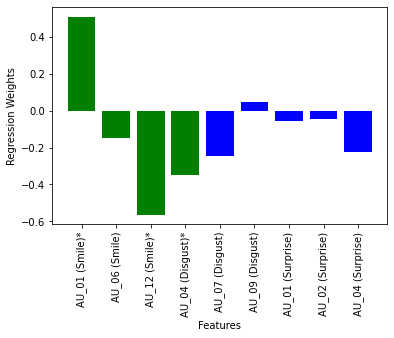

In [ ]:
feats = ['AU_01_t12','AU_06_t12','AU_12_t12','AU_04_t13','AU_07_t13', 'AU_09_t13','AU_01_t14','AU_02_t14','AU_04_t14']
X = df[feats].dropna()
y = df['diagnosed'].dropna()
X = scale(X)
y = np.array(y)
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
results = sm.Logit(y_resampled,X_resampled).fit(method='bfgs')
print(results.summary())


print(len(results.params))
feat_names = ['AU_01 (Smile)*','AU_06 (Smile)','AU_12 (Smile)*','AU_04 (Disgust)*','AU_07 (Disgust)', 'AU_09 (Disgust)',\
              'AU_01 (Surprise)','AU_02 (Surprise)','AU_04 (Surprise)']
plt.bar(np.arange(9),results.params,color = 'gbgggbbbb') 
plt.bar(np.arange(9),results.params,color = 'ggggbbbbb') 
plt.xlabel("Features")
plt.ylabel("Regression Weights")
plt.xticks(np.arange(9),feat_names,rotation=90)
plt.savefig("Regression_weights.png",bbox_inches='tight',dpi = 300)
plt.show()

<h2>Clustering Analysis</h2>

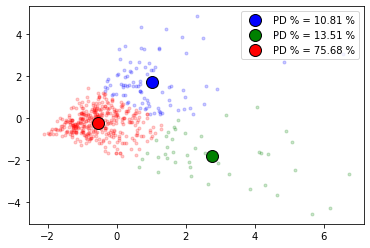

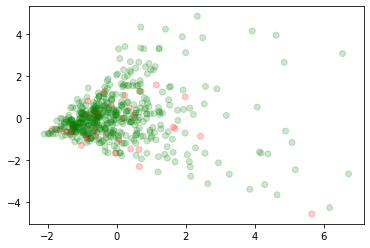

<Figure size 432x288 with 0 Axes>

In [ ]:
X = df[feats].dropna()
y = df['diagnosed'].dropna()
X = scale(X)
y = np.array(y)

    
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
m = 0
t = []
pca = PCA(n_components=2)
x_new = pca.fit_transform(X)

kmeans = KMeans(init= 'k-means++', n_clusters=3, random_state=0).fit(x_new)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

means = []
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
#     print(sum(y[my_members])/(sum(y)),sum(y[my_members]))
    means.append(np.mean(X[my_members],axis=0))
    cluster_center = cluster_centers[k]
    
    plt.plot(x_new[my_members, 0], x_new[my_members, 1], col + '.', alpha=0.2)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=12,\
             label = "PD % = "+str(np.around(sum(y[my_members])/(sum(y) /100),decimals=2))+" %")
    plt.legend(loc = 'upper right')
    plt.savefig('figs/clusters.png',bbox_inches='tight',dpi = 300)
plt.show()
plt.clf() 
c = ['g' if i == 0 else 'r' for i in y]
plt.scatter(x_new[:,0],x_new[:,1],c = c,alpha=0.2)
plt.show()
plt.clf()

<h2>Classification</h2>

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,precision_score, recall_score
from collections import Counter
feats = ['AU_01_t12','AU_06_t12','AU_12_t12','AU_04_t13','AU_07_t13', 'AU_09_t13','AU_01_t14','AU_02_t14','AU_04_t14']
X = df[feats].dropna()
y = df['diagnosed'].dropna()
X = scale(X)
# print(sum(y)/len(y))
y = np.array(y)
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
best_auc = 0
best_f1 = 0
best_acc = 0
best_pre = 0
best_re = 0
for c in np.arange(0.1,10,2):
    for g in np.arange(0.1,2,0.05):
        clf = svm.SVC(kernel = 'rbf', C = c, gamma = g).fit(X_resampled,y_resampled)
#         clf = svm.SVC(kernel = 'linear', C = c)
        y_pred = cross_val_predict(clf, X_resampled, y_resampled, cv=10)
        acc = accuracy_score(y_resampled,y_pred)
        auc = roc_auc_score(y_resampled,y_pred)
        f1 = f1_score(y_resampled,y_pred)
        pre = precision_score(y_resampled,y_pred)
        re = recall_score(y_resampled,y_pred)
        if (auc>best_auc):
            best_auc = auc
            best_f1 = f1
            best_acc = acc
            best_pre = pre
            best_re = re
print(best_acc, best_f1, best_auc, best_pre, best_re)


0.95625 0.9563409563409564 0.9562500000000002 0.9543568464730291 0.9583333333333334


Until here, the code was the paper's original. From here on - changed code

The following cell shows that if the y is shuffled, the auc, precision stays the same because SMOTE causes data leak from train to test.

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,precision_score, recall_score
from collections import Counter
feats = ['AU_01_t12','AU_06_t12','AU_12_t12','AU_04_t13','AU_07_t13', 'AU_09_t13','AU_01_t14','AU_02_t14','AU_04_t14']
X = df[feats].dropna()
y = df['diagnosed'].dropna()
X = scale(X)
# print(sum(y)/len(y))
y = np.array(y)

##THE FOLLOWING 3 LINES ARE THE ONLY CHANGED CODE FROM ORIGINAL CELL
print(y[:20])
np.random.shuffle(y)
print(y[:20])

X_resampled, y_resampled = SMOTE().fit_resample(X, y)
best_auc = 0
best_f1 = 0
best_acc = 0
best_pre = 0
best_re = 0
for c in np.arange(0.1,10,2):
    for g in np.arange(0.1,2,0.05):
        clf = svm.SVC(kernel = 'rbf', C = c, gamma = g).fit(X_resampled,y_resampled)
#         clf = svm.SVC(kernel = 'linear', C = c)
        y_pred = cross_val_predict(clf, X_resampled, y_resampled, cv=10)
        acc = accuracy_score(y_resampled,y_pred)
        auc = roc_auc_score(y_resampled,y_pred)
        f1 = f1_score(y_resampled,y_pred)
        pre = precision_score(y_resampled,y_pred)
        re = recall_score(y_resampled,y_pred)
        if (auc>best_auc):
            best_auc = auc
            best_f1 = f1
            best_acc = acc
            best_pre = pre
            best_re = re
print(best_acc, best_f1, best_auc, best_pre, best_re)

[1 1 0 1 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1]
0.9604166666666667 0.9611451942740286 0.9604166666666666 0.9437751004016064 0.9791666666666666


The following shows auc calculated without SMOTE (and with xgboost)

In [ ]:
from xgboost import XGBRegressor

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,precision_score, recall_score
from collections import Counter
feats = ['AU_01_t12','AU_06_t12','AU_12_t12','AU_04_t13','AU_07_t13', 'AU_09_t13','AU_01_t14','AU_02_t14','AU_04_t14']
X = df[feats].dropna()
y = df['diagnosed'].dropna()
X = scale(X)
# print(sum(y)/len(y))
y = np.array(y)
X_resampled, y_resampled = X,y
best_auc = 0
best_f1 = 0
best_acc = 0
best_pre = 0
best_re = 0
# for c in np.arange(0.1,10,2):
#     for g in np.arange(0.1,2,0.05):
clf = XGBRegressor(objective='binary:logistic',eval_metric='auc')
#         clf = svm.SVC(kernel = 'linear', C = c)
y_pred = cross_val_predict(clf, df.drop(columns=['diagnosed','id']), df['diagnosed'], cv=len(df))
acc = accuracy_score(y_resampled,[round(a) for a in y_pred])
auc = roc_auc_score(y_resampled,y_pred)
f1 = f1_score(y_resampled,[round(a) for a in y_pred])
pre = precision_score(y_resampled,[round(a) for a in y_pred])
re = recall_score(y_resampled,[round(a) for a in y_pred])
if (auc>best_auc):
    best_auc = auc
    best_f1 = f1
    best_acc = acc
    best_pre = pre
    best_re = re
print(best_acc, best_f1, best_auc, best_pre, best_re)


0.9439071566731141 0.4081632653061225 0.7568693693693694 0.8333333333333334 0.2702702702702703


The following images are used to show the leakage

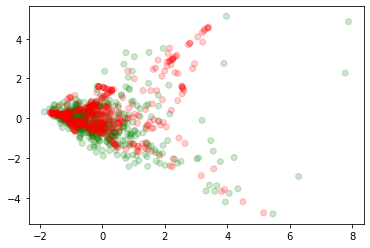

<Figure size 432x288 with 0 Axes>

In [ ]:
X = df[feats].dropna()
y = df['diagnosed'].dropna()
X = scale(X)
y = np.array(y)

X, y = SMOTE().fit_resample(X, y)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
m = 0
t = []
pca = PCA(n_components=2)
x_new = pca.fit_transform(X)

kmeans = KMeans(init= 'k-means++', n_clusters=3, random_state=0).fit(x_new)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

means = []
# for k, col in zip(range(n_clusters_), colors):
#     my_members = labels == k
# #     print(sum(y[my_members])/(sum(y)),sum(y[my_members]))
#     means.append(np.mean(X[my_members],axis=0))
#     cluster_center = cluster_centers[k]
    
#     plt.plot(x_new[my_members, 0], x_new[my_members, 1], col + '.', alpha=0.2)
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=12,\
#              label = "PD % = "+str(np.around(sum(y[my_members])/(sum(y) /100),decimals=2))+" %")
#     plt.legend(loc = 'upper right')
# plt.show()
# plt.clf() 
c = ['g' if i == 0 else 'r' for i in y]
plt.scatter(x_new[:,0],x_new[:,1],c = c,alpha=0.2)
plt.savefig('new_figs/scatter_smote.png',bbox_inches='tight',dpi = 300)

plt.show()
plt.clf()

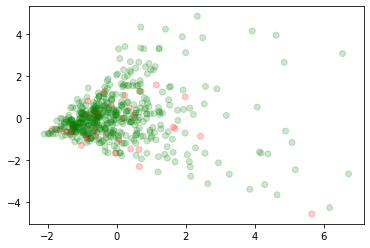

<Figure size 432x288 with 0 Axes>

In [ ]:
X = df[feats].dropna()
y = df['diagnosed'].dropna()
X = scale(X)
y = np.array(y)

# X, y = SMOTE().fit_resample(X, y)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
m = 0
t = []
pca = PCA(n_components=2)
x_new = pca.fit_transform(X)

kmeans = KMeans(init= 'k-means++', n_clusters=3, random_state=0).fit(x_new)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

means = []
# for k, col in zip(range(n_clusters_), colors):
#     my_members = labels == k
# #     print(sum(y[my_members])/(sum(y)),sum(y[my_members]))
#     means.append(np.mean(X[my_members],axis=0))
#     cluster_center = cluster_centers[k]
    
#     plt.plot(x_new[my_members, 0], x_new[my_members, 1], col + '.', alpha=0.2)
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=12,\
#              label = "PD % = "+str(np.around(sum(y[my_members])/(sum(y) /100),decimals=2))+" %")
#     plt.legend(loc = 'upper right')
# plt.show()
# plt.clf() 
c = ['g' if i == 0 else 'r' for i in y]
plt.scatter(x_new[:,0],x_new[:,1],c = c,alpha=0.2)
plt.savefig('new_figs/scatter.png',bbox_inches='tight',dpi = 300)

plt.show()
plt.clf()